In [216]:
import glob, serial, time, math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import iradon
from IPython.display import display

In [181]:
ports = glob.glob('/dev/tty[A-Za-z]*') # Modify if on a platform other than Linux
ports[0]

'/dev/ttyACM2'

In [182]:
ser = serial.Serial(ports[0], 115200)

In [178]:
a_steps = 640 # Steps per revolution - 200 * 80/25
b_steps = 1280 # 160 teeth -> 200*160/25

apos = 0
bpos = 0

read = ''

def step_a(n):
    message = b'a'
    if n < 0:
        n = -n
        message = b'A'
    for i in range(n):
        ser.write(message)
        while ser.in_waiting < 1:
            pass # wait for a response
        read = ser.read_all()
#         print(read)
    return n

def set_a(angle):
    step_coords = int(angle/(2*math.pi) * a_steps) # Angle in radians
    step_a(step_coords - apos)
    return step_coords

def step_b(n):
    message = b'b'
    if n < 0:
        n = -n
        message = b'B'
    for i in range(n):
        ser.write(message)
        while ser.in_waiting < 1:
            pass # wait for a response
        read = ser.read_all()
#         print(read)
    return n

def set_b(angle):
    step_coords = int(angle/(2*math.pi) * b_steps) # Angle in radians
    step_b(step_coords - bpos)
    return step_coords

def read_adc():
    ser.write(b'E')
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

# apos = set_a(0.2) # This is the proper usage to keep track
# print(apos)

We can move the A and B axes with step_a(n_steps) or set_a(angle in radians). A is the inner circle, B the outer.

Let's take one really detailed scan using the B axis to see what our beam shape looks like. 0 to 180 degrees by stepping B 640 times (half a revolution) reading the adc 3 times each position and averaging:

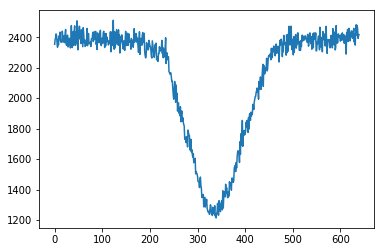

In [172]:
base = []
for b in range(640):
    val = 0
    for i in range(3):
        val += int(read_adc().strip())
    base.append(val)
    step_b(1)
    
step_b(-640) # return to start
plt.plot(base)

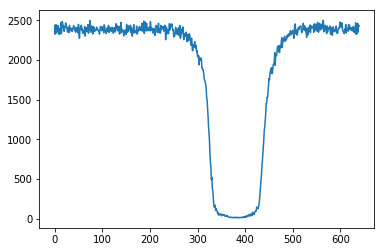

In [173]:
# Changing to a non-sanded bulb:
base = []
for b in range(640):
    val = 0
    for i in range(3):
        val += int(read_adc().strip())
    base.append(val)
    step_b(1)
    
step_b(-640) # return to start
plt.plot(base)

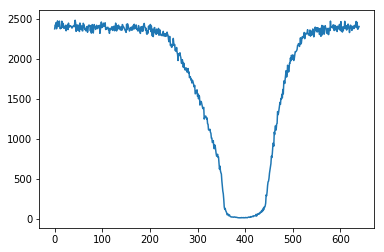

In [179]:
# Trying both at once
base = []
for b in range(640):
    val = 0
    for i in range(3):
        val += int(read_adc().strip())
    base.append(val)
    step_b(1)
    
step_b(-640) # return to start
plt.plot(base)


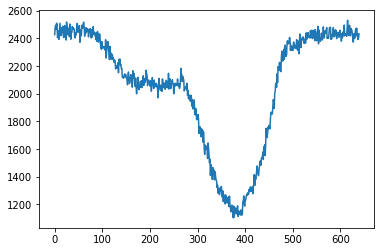

In [183]:
# Trying both at once
base = []
for b in range(640):
    val = 0
    for i in range(3):
        val += int(read_adc().strip())
    base.append(val)
    step_b(1)
    
step_b(-640) # return to start
plt.plot(base)

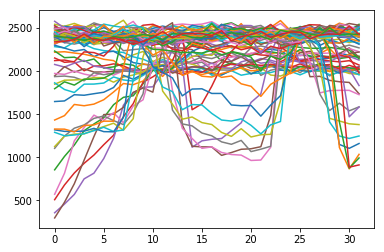

In [213]:
# Now, doing these scans from several angles. Doing 32 As (views/thetas), 64 Bs for each A (64 sensors)
from IPython.display import clear_output
readings = []
for a in range(32):
    line = []
    for b in range(64):
        val = 0
        for i in range(3):
            val += int(read_adc().strip())
        line.append(val)
        step_b(10)
    readings.append(line)
    # Plot so we have something to stare at
    plt.clf()
    plt.plot(line)
    plt.show()
    clear_output(wait=True)
    step_a(20) # A has 640 steps in 360 degrees. Scanning from 32 different views
    step_b(-640) # return to start


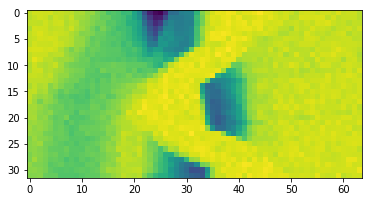

In [214]:
plt.imshow(readings) # Plot the sinogram

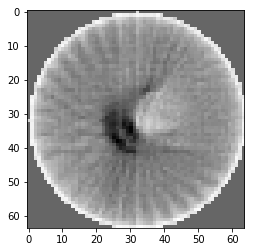

In [222]:
# Use an outy-of-the-box alg to 
reconstruction_fbp = iradon(np.asarray(readings).T, theta=[i*360/32 for i in range(32)], circle=True)
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()

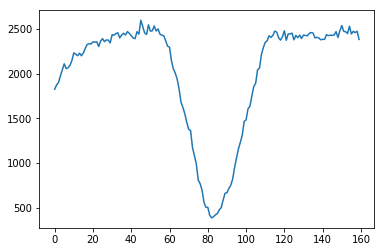

In [238]:
# Now, doing these scans from several angles. Doing 32 As (views/thetas), 64 Bs for each A (64 sensors)
from IPython.display import clear_output
readings2 = []
for a in range(32):
    line = []
    for b in range(160):
        val = 0
        for i in range(3):
            val += int(read_adc().strip())
        line.append(val)
        step_b(4)
    readings2.append(line)
    # Plot so we have something to stare at
    plt.clf()
    plt.plot(line)
    plt.show()
    clear_output(wait=True)
    step_a(20) # A has 640 steps in 360 degrees. Scanning from 32 different views
    step_b(-640) # return to start


In [239]:
r = np.asarray(readings2)

In [240]:
r.shape

(32, 160)

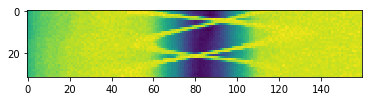

In [241]:
plt.imshow(r)

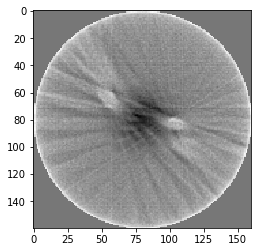

In [244]:
reconstruction_fbp = iradon(r.T, theta=[i*360/32 for i in range(32)], circle=True)
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()

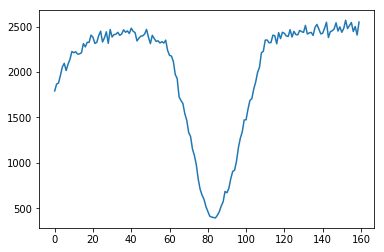

In [246]:
# Trying both at once
base = []
for b in range(160):
    val = 0
    for i in range(3):
        val += int(read_adc().strip())
    base.append(val)
    step_b(4)
plt.plot(base)
step_b(-640) # return to start


In [247]:
r2 = [x - base for x in r]

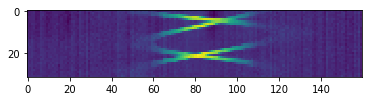

In [249]:
plt.imshow(r2)

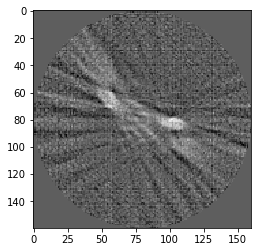

In [301]:
reconstruction_fbp = iradon(np.asarray(r2).T, theta=[i*360/32 for i in range(32)], circle=True)
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()

Using some post-processing to smooth things out and locate the objects we're interested in. Does a simple threshold, some erosion and then dialation to get very well defined (but blocky) blobs.

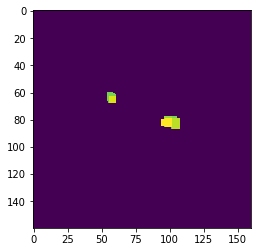

In [303]:
from skimage import morphology
idx = reconstruction_fbp[:][:] < 20
reconstruction_fbp[idx] = 0
eroded_leg = morphology.erosion(reconstruction_fbp,np.ones([4,4]))
leg = morphology.dilation(eroded_leg,np.ones([5,5]))
plt.imshow(leg)

In [310]:
# Saving our hard work:
pd.DataFrame(r).to_csv('12Aug_R_two_pens.csv', index=False)
pd.DataFrame(base).to_csv('12Aug_BASE_two_pens.csv', index=False)
pd.DataFrame(base).to_csv('12Aug_R2_two_pens.csv', index=False)

In [308]:
d = pd.read_csv('12Aug_R_two_pens.csv')
d.head()

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,1661,1754,1793,1906,1874,1902,2005,2013,2009,2083,...,2467,2407,2389,2452,2478,2444,2458,2467,2429,2453
1,1677,1783,1825,1945,1897,1954,2005,2082,2072,2044,...,2460,2547,2466,2437,2480,2478,2504,2491,2515,2424
2,1653,1768,1836,1918,1893,1935,2042,2126,2047,2128,...,2460,2528,2413,2385,2461,2483,2437,2424,2434,2392
3,1724,1807,1825,1921,1886,1965,2031,2031,2079,2023,...,2445,2503,2442,2473,2494,2406,2452,2443,2453,2444
4,1661,1802,1825,1930,1868,1956,2041,1988,2058,2025,...,2384,2445,2382,2415,2400,2396,2446,2443,2451,2394
